# Pacoes e classes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from funcoes.buscar_dados import Temperature, Load
from funcoes.equacoes import  tabela_equacoes
from funcoes.graficos import plotar_graficos, grid_graficos, grid_graficos_estacoes
from funcoes.estacao_ano import estacao_do_ano
from funcoes.funcoes_gerais import trocar_temp, preparar_df_long_com_ponderada
from funcoes.funcoes_teste import treinamento_media_simples, treinamento_ponderado_por_zona_cv, treinamento_por_weather_zone_cv
import gridstatus as gs
from gridstatus import Ercot
import datetime as dt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# credencias
api_key = '41ac637ac7464f6da57351ed3fa5e5ff'
start_date = "2023-09-01"
end_date = "2024-09-01"

# Lendo arquivos baixados pela api
filtrar de 2023/09 até 2024/09 todas as horas da carga

In [3]:
# df_t = pd.read_csv('C:/Users/joao.pinheiro/OneDrive - Serena/Área de Trabalho/df_temp.csv')
# df_l = pd.read_csv('C:/Users/joao.pinheiro/OneDrive - Serena/Área de Trabalho/df_load.csv')

df_t = pd.read_csv('C:/Users/Computadores Gamer/OneDrive/Área de Trabalho/dados_tcc/df_temp.csv')
df_l = pd.read_csv('C:/Users/Computadores Gamer/OneDrive/Área de Trabalho/dados_tcc/df_load.csv')

In [4]:
# Tratamentos iniciais
for df in [df_l, df_t]:
    df["interval_start_utc"] = pd.to_datetime(df["interval_start_utc"]).dt.tz_localize(None)
    df["interval_end_utc"] = pd.to_datetime(df["interval_end_utc"], utc=True).dt.tz_localize(None)
    df["publish_time_utc"] = pd.to_datetime(df["publish_time_utc"], utc=True).dt.tz_localize(None)
    
df_t = df_t.drop(columns=["Unnamed: 0"], errors="ignore")
df_l = df_l.drop(columns=["Unnamed: 0", "publish_time_utc_load",'publish_time_utc_tf'], errors="ignore")


df_t = df_t[['interval_start_utc', 'interval_end_utc', 'publish_time_utc', 'coast',
        'east', 'far_west', 'north', 'north_central', 'south_central',
        'southern', 'west', 'hour', 'weekday', 'avg_temp_fahrenheit']]


In [5]:
df = pd.merge(
    df_l,
    df_t,
    on=["interval_start_utc", "interval_end_utc"],
    how="inner",
    suffixes=['_carga','_tf']
)

df = trocar_temp(df)
df['publish_time_utc_carga'] = pd.to_datetime(df['publish_time_utc_carga'])


hora = dt.time(10, 30) 
df = df[(df['publish_time_utc_carga'].dt.time == hora)]


# Dia da semana

In [6]:
df_dia_semana = df.copy()
df_dia_semana['publish_time_utc_carga'] = pd.to_datetime(df_dia_semana['publish_time_utc_carga'])
df_dia_semana['dia'] = df_dia_semana['publish_time_utc_carga'].dt.day_name()
df_dia_semana['ano']= df_dia_semana['publish_time_utc_carga'].dt.year
df_dia_semana['mes']= df_dia_semana['publish_time_utc_carga'].dt.month

df_dia_semana.replace([np.inf, -np.inf], np.nan, inplace=True)
df_dia_semana['estacao'] = df_dia_semana['publish_time_utc_carga'].apply(estacao_do_ano)


# Graficos de temperatura por estacao do ano

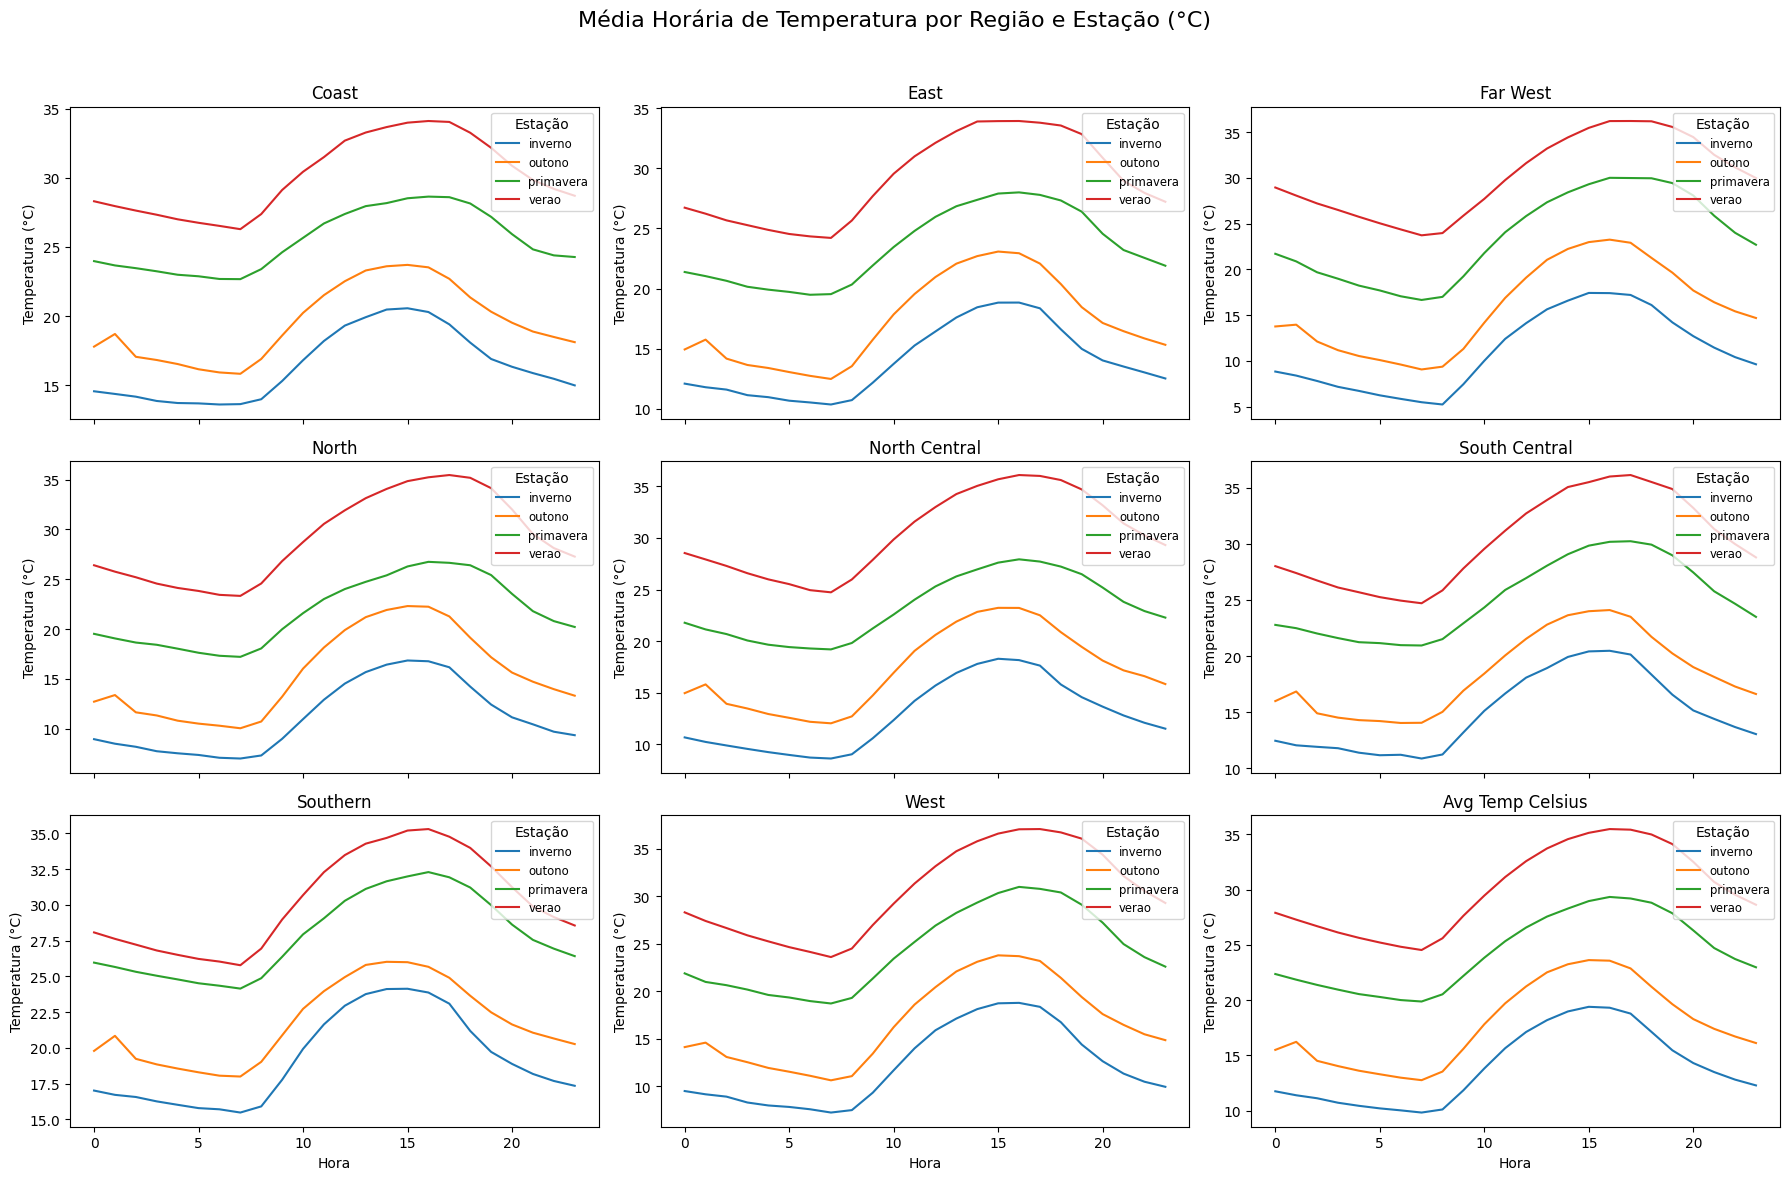

In [7]:
# Lista apenas com colunas de temperatura em Celsius
regioes_tc = [
    'coast_tc', 'east_tc', 'far_west_tc',
    'north_tc', 'north_central_tc', 'south_central_tc',
    'southern_tc', 'west_tc', 'avg_temp_celsius'
]

# Configura figura 3x3
fig, axes = plt.subplots(3, 3, figsize=(18, 12), sharex=True)
axes = axes.flatten()

# Criar gráfico para cada região
for i, regiao in enumerate(regioes_tc):
    df_regiao = df_dia_semana.groupby(['estacao', 'hour'])[regiao].mean().reset_index()

    sns.lineplot(
        data=df_regiao,
        x='hour',
        y=regiao,
        hue='estacao',
        palette='tab10',
        ax=axes[i]
    )
    
    # Títulos e estética
    nome_formatado = regiao.replace('_tc', '').replace('_', ' ').title()
    axes[i].set_title(f'{nome_formatado}')
    axes[i].set_xlabel('Hora')
    axes[i].set_ylabel('Temperatura (°C)')
    axes[i].legend(title='Estação', fontsize='small', loc='upper right')

# Ajustes finais
plt.suptitle('Média Horária de Temperatura por Região e Estação (°C)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Graficos de carga por estacao do ano

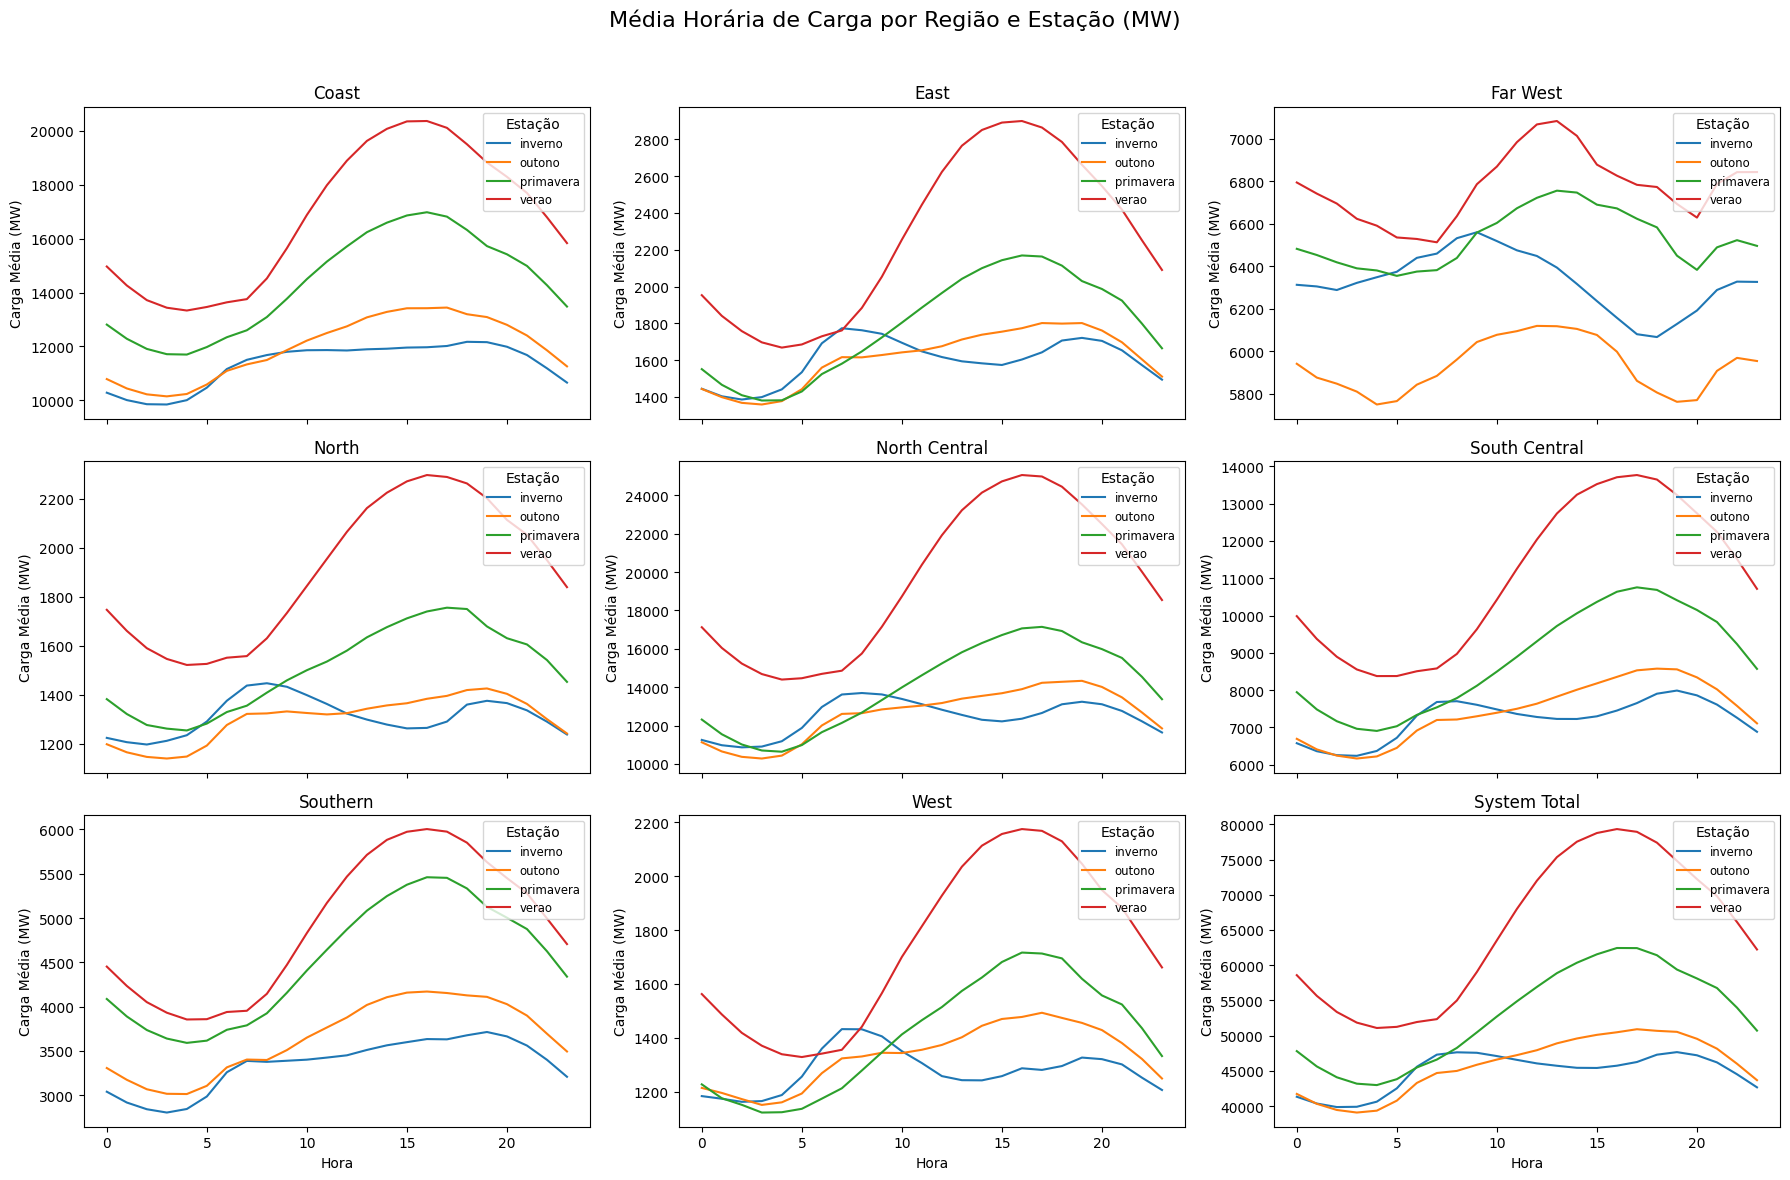

In [8]:
# Lista com os nomes das 9 regiões (colunas de carga)
regioes_carga = [
    'coast_carga', 'east_carga', 'far_west_carga',
    'north_carga', 'north_central_carga', 'south_central_carga',
    'southern_carga', 'west_carga', 'system_total'
]

# Configura figura 3x3
fig, axes = plt.subplots(3, 3, figsize=(18, 12), sharex=True)
axes = axes.flatten()

# Criar gráfico para cada região
for i, regiao in enumerate(regioes_carga):
    df_regiao = df_dia_semana.groupby(['estacao', 'hour'])[regiao].mean().reset_index()

    sns.lineplot(
        data=df_regiao,
        x='hour',
        y=regiao,
        hue='estacao',
        palette='tab10',
        ax=axes[i]
    )
    
    # Títulos e estética
    nome_formatado = regiao.replace('_carga', '').replace('_', ' ').title()
    axes[i].set_title(f'{nome_formatado}')
    axes[i].set_xlabel('Hora')
    axes[i].set_ylabel('Carga Média (MW)')
    axes[i].legend(title='Estação', fontsize='small', loc='upper right')

# Ajustes finais
plt.suptitle('Média Horária de Carga por Região e Estação (MW)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


# Comparativo entre temperatura vs carga ambos por estacao

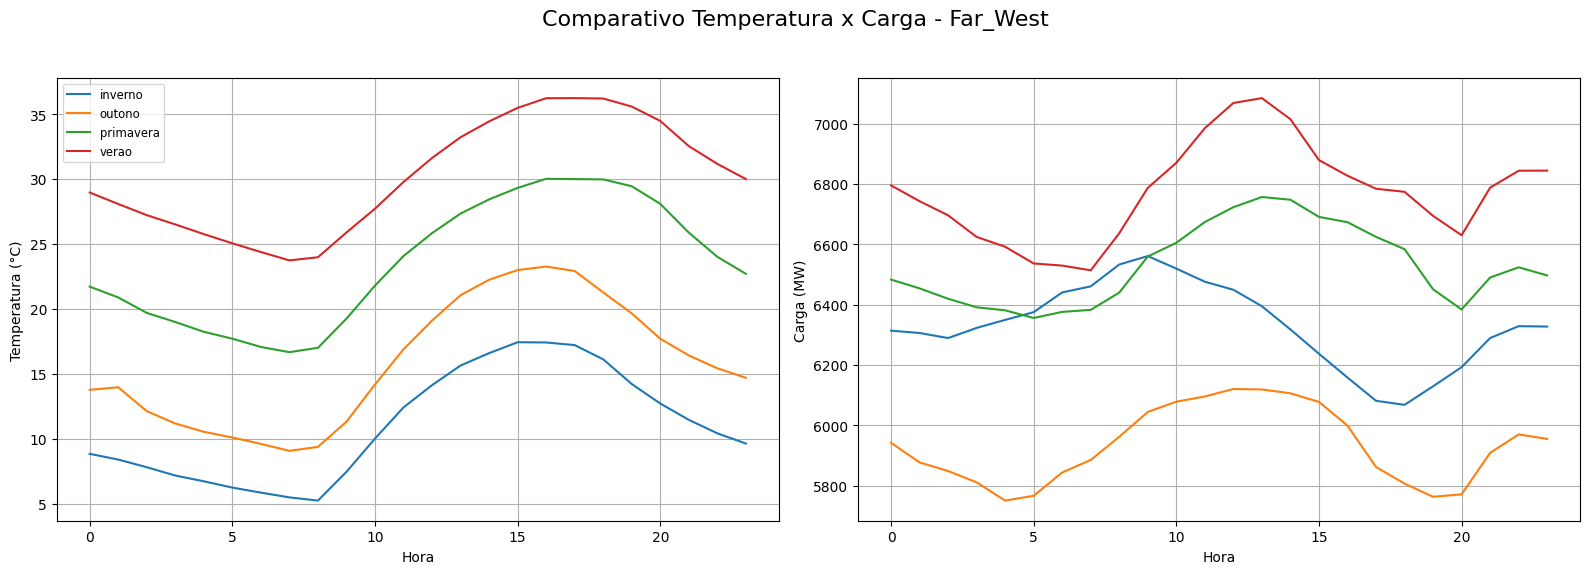

In [9]:
def comparar_temp_carga_estacoes(df, regiao_tc):
    regiao_nome = regiao_tc.replace('_tc', '')
    regiao_carga = f'{regiao_nome}_carga'

    # Agrupar dados por estação e hora
    df_temp = df.groupby(['estacao', 'hour'])[regiao_tc].mean().reset_index()
    df_carga = df.groupby(['estacao', 'hour'])[regiao_carga].mean().reset_index()

    estacoes = sorted(df['estacao'].dropna().unique())

    # Criar figura com 2 subplots
    fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharex=True)

    # --- Gráfico de Temperatura ---
    sns.lineplot(data=df_temp, x='hour', y=regiao_tc, hue='estacao', palette='tab10', ax=axs[0])
    # axs[0].set_title(f'Temperatura por Estação - {regiao_nome.title()}')
    axs[0].set_xlabel('Hora')
    axs[0].set_ylabel('Temperatura (°C)')
    axs[0].grid(True)

    # --- Gráfico de Carga ---
    sns.lineplot(data=df_carga, x='hour', y=regiao_carga, hue='estacao', palette='tab10',dashes=True, ax=axs[1])
    # axs[1].set_title(f'Carga por Estação - {regiao_nome.title()}')
    axs[1].set_xlabel('Hora')
    axs[1].set_ylabel('Carga (MW)')
    axs[1].grid(True)

    # Ajuste da legenda
    axs[1].legend_.remove()  # Remove legenda duplicada
    axs[0].legend( fontsize='small')

    # Layout final
    plt.suptitle(f'Comparativo Temperatura x Carga - {regiao_nome.title()}', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


comparar_temp_carga_estacoes(df_dia_semana, 'far_west_tc')

In [10]:
tabela_equacoes(df = df , n_weekday = 1)

,Hora,avg_temp_celsius,coast_tc,east_tc,far_west_tc,north_tc,north_central_tc,south_central_tc,southern_tc,west_tc
0,0,y = 89.36x² -2424.62x + 55507.53,y = 25.74x² -737.48x + 15144.30,y = 3.50x² -101.87x + 2086.66,y = 2.14x² -52.82x + 6473.50,y = 2.19x² -48.88x + 1436.16,y = 29.17x² -807.08x + 15670.57,y = 16.20x² -423.32x + 8838.45,y = 9.16x² -287.16x + 5187.07,y = 1.95x² -53.86x + 1466.04
1,1,y = 89.65x² -2440.69x + 54394.81,y = 24.83x² -715.94x + 14761.71,y = 3.30x² -96.25x + 2002.96,y = 2.20x² -52.84x + 6439.73,y = 2.12x² -47.71x + 1405.28,y = 29.53x² -821.44x + 15325.52,y = 15.90x² -414.88x + 8500.17,y = 9.18x² -287.08x + 5048.38,y = 2.00x² -56.14x + 1460.57
2,2,y = 88.05x² -2391.05x + 53296.77,y = 23.05x² -653.19x + 14054.07,y = 3.32x² -98.18x + 1993.72,y = 2.10x² -46.66x + 6362.85,y = 2.11x² -47.76x + 1383.65,y = 28.97x² -802.85x + 14956.93,y = 15.37x² -402.99x + 8339.19,y = 8.79x² -274.18x + 4868.89,y = 1.96x² -55.03x + 1435.67
3,3,y = 87.43x² -2365.74x + 52880.95,y = 22.58x² -639.24x + 13937.15,y = 3.25x² -96.84x + 1980.81,y = 1.99x² -42.78x + 6319.51,y = 2.05x² -46.71x + 1380.41,y = 29.54x² -813.88x + 14892.72,y = 14.85x² -390.29x + 8254.68,y = 8.56x² -265.23x + 4763.10,y = 1.95x² -54.87x + 1424.98
4,4,y = 87.37x² -2371.47x + 53486.75,y = 21.92x² -619.26x + 13980.40,y = 3.26x² -98.64x + 2034.75,y = 1.98x² -41.48x + 6295.49,y = 2.05x² -46.83x + 1392.46,y = 29.03x² -803.35x + 15059.83,y = 14.02x² -368.99x + 8242.93,y = 8.79x² -277.89x + 4934.11,y = 1.94x² -54.96x + 1437.70
5,5,y = 87.18x² -2406.62x + 55868.94,y = 22.07x² -636.67x + 14735.61,y = 3.24x² -100.47x + 2147.52,y = 1.85x² -39.58x + 6306.06,y = 1.91x² -44.66x + 1446.71,y = 28.97x² -818.37x + 15980.37,y = 13.09x² -350.17x + 8558.41,y = 8.40x² -268.61x + 5037.75,y = 1.83x² -53.15x + 1482.30
6,6,y = 82.09x² -2335.92x + 59186.51,y = 20.27x² -596.45x + 15296.55,y = 2.92x² -95.19x + 2298.57,y = 1.62x² -35.68x + 6374.58,y = 1.78x² -43.38x + 1543.62,y = 26.40x² -769.20x + 17075.07,y = 12.63x² -359.13x + 9401.66,y = 7.64x² -250.78x + 5266.55,y = 1.69x² -52.10x + 1590.34
7,7,y = 80.11x² -2305.72x + 60753.66,y = 21.27x² -639.93x + 16021.37,y = 2.84x² -93.57x + 2351.84,y = 1.35x² -28.75x + 6364.89,y = 1.74x² -44.00x + 1601.57,y = 26.33x² -785.00x + 17924.60,y = 11.45x² -329.77x + 9583.37,y = 7.85x² -263.92x + 5540.03,y = 1.54x² -48.49x + 1625.83
8,8,y = 84.08x² -2412.44x + 61668.18,y = 22.56x² -688.51x + 16590.44,y = 3.09x² -99.07x + 2377.52,y = 2.07x² -47.89x + 6509.62,y = 1.79x² -43.72x + 1598.21,y = 26.39x² -776.50x + 17912.06,y = 14.29x² -419.30x + 10168.87,y = 8.63x² -293.52x + 5768.59,y = 1.53x² -44.37x + 1588.26
9,9,y = 87.84x² -2650.48x + 65128.78,y = 23.22x² -732.82x + 17390.56,y = 3.58x² -119.22x + 2592.76,y = 2.05x² -48.85x + 6611.81,y = 1.86x² -47.55x + 1642.21,y = 28.12x² -861.02x + 19000.34,y = 18.12x² -578.57x + 11696.81,y = 9.10x² -324.64x + 6227.02,y = 1.70x² -49.66x + 1644.41


# Grid de gráficos por regiao e parametrizando uma hora por vez

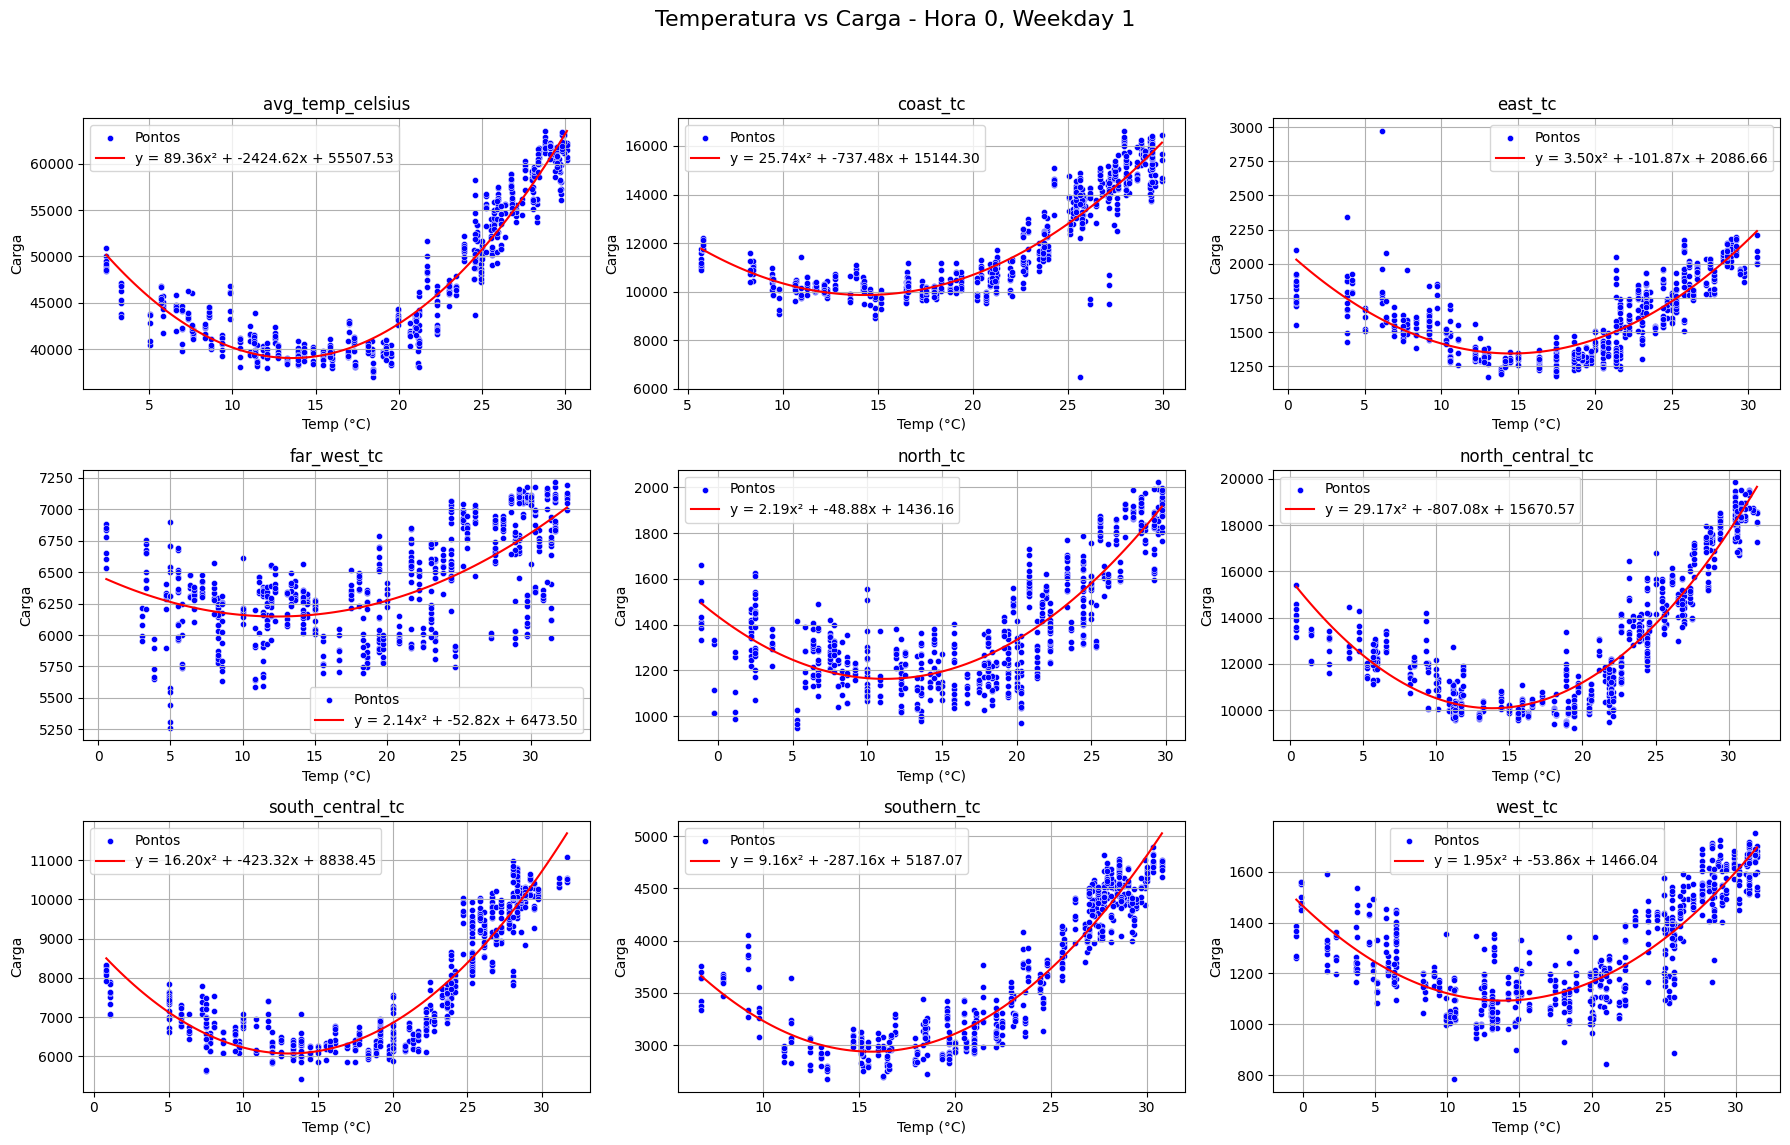

In [11]:
grid_graficos(df= df, hour=0, weekday= 1)

# DF long
- aqui ja criarei a coluna da temperatura ponderada pela populacao do condado , será usado apenas no teste 2
- a tabela ja servirá para os teste 1 e 2
- a tabela 3 usará o df original

In [12]:
# dados da populacao do texas
pop_texas = pd.read_csv('C:/Users/Computadores Gamer/OneDrive/Área de Trabalho/serena-tcc/dados/pop_texas.csv')
pop_texas = pop_texas.drop_duplicates(keep = 'first', subset=['COUNTY'])

In [13]:
# Aqui transforma a tabela em long e ja vem com a temp_ponderada pela população
df_pond_long = preparar_df_long_com_ponderada(df, pop_texas)

# Parametros gerais

In [24]:
n_weekday = 0
hour = 2

# Teste 1
- treinamento com a carga total vs media simples temperatura do estado
- usando regressão linear com Mínimos Quadrados Ordinários
- PolynomialFeatures(degree=2), dados com termos quadráticos

- Você transforma a variável X (temperatura média) em: 
    1 (termo constante)

    X (linear)

    X² (quadrático)

- Depois ajusta a equação do tipo:
 y_hat = 𝛽0 + 𝛽1X + 𝛽2X²

-  E os coeficientes 𝛽 são estimados por MQO

In [ ]:
tabela1 = treinamento_media_simples(df_pond_long, n_weekday , hour)
tabela1

,equacao,RMSE Treino,RMSE Teste,RMSE Validação,R² Treino,R² Teste,R² Validação,CV RMSE Médio,CV RMSE DP
0,y = 16x² + -326x + 11038,674.015644,529.260303,811.526406,0.874487,0.922638,0.757051,3179.244373,3491.75583


### RMSE
O que é:
É a raiz do erro quadrático médio — ou seja, mede o quão distante, em média, as previsões estão dos valores reais, na mesma unidade da variável dependente, que aqui é MW de carga.

Como interpretar:

Um RMSE de 1523.89 MW significa que, em média, a previsão do modelo está errando a carga por cerca de 1.524 MW.

Se a carga total média do sistema estiver, por exemplo, em torno de 18.000 MW, esse erro representa aproximadamente 8,5% da carga — o que pode ser razoável ou bom, dependendo da variabilidade natural da carga.


### R²
O que é:
Indica quanto da variabilidade da carga o modelo consegue explicar com a temperatura.

Como interpretar:

Um R² de 0.825 significa que o modelo explica 82,5% da variação na carga elétrica com base na temperatura.

Isso é um valor bastante forte, principalmente se estamos usando apenas uma variável (temperatura) para prever a carga.

Em problemas reais, R² acima de 0.8 é geralmente considerado muito bom, especialmente com séries temporais ou dados ambientais.

# Teste 2
- treinamento com a carga total vs media ponderada temperatura do estado (ponderada por carga historica ou população)
- a populacao será de cada condado do Texas (214 condados), por que o ERCOT nao engloba tudo, quase 90%


In [16]:
tabela2 = treinamento_ponderado_por_zona_cv(df_pond_long, n_weekday , hour)
tabela2

,regiao,equacao,RMSE Treino,R² Treino,RMSE Teste,R² Teste,RMSE Validação,R² Validação,CV RMSE Médio,CV RMSE DP
0,coast,y = 17.94x² -327.25x + 11733.52,915.761625,0.858692,917.449326,0.868259,877.384691,0.871100,883.601984,36.568912
1,east,y = 3.43x² -86.04x + 1861.13,112.551785,0.858479,119.249685,0.846461,111.924273,0.856053,112.243933,8.084818
2,far_west,y = 2.44x² -49.31x + 6315.30,332.096142,0.405420,339.046003,0.446166,320.945672,0.454088,323.775877,32.868196
3,north,y = 2.48x² -58.55x + 1532.86,138.369491,0.719974,142.864101,0.728144,141.057263,0.717136,143.672903,12.047840
4,north_central,y = 32.88x² -791.12x + 15125.85,1019.836845,0.887412,1063.000832,0.878401,988.758857,0.891326,990.298607,64.535829
5,south_central,y = 14.60x² -296.01x + 7944.98,659.497334,0.859353,704.508685,0.846636,627.510159,0.872748,629.671460,37.501197
6,southern,y = 3.46x² -36.74x + 3257.64,335.343396,0.779095,346.384129,0.768383,338.777162,0.771479,340.051222,19.326012
7,west,y = 2.31x² -55.42x + 1473.41,99.407353,0.806610,103.286230,0.776884,99.506892,0.797157,99.743051,7.997892


# Teste 3
- treinamento com carga por weather_zone vs temperatura por weather zone (é o que eu ja fiz)

In [17]:
tabela3 = treinamento_por_weather_zone_cv(df = df, weekday=n_weekday ,  hora = hour)
tabela3

,weather_zone,equacao,RMSE Treino,R² Treino,RMSE Teste,R² Teste,RMSE Validação,R² Validação,CV RMSE Médio,CV RMSE DP
0,coast,y = 30.06x² -876.33x + 16496.34,730.906590,0.908571,646.327831,0.930931,664.839950,0.922663,666.050199,84.647705
1,east,y = 3.41x² -93.95x + 2007.75,137.988158,0.774071,107.231418,0.864681,130.809657,0.809458,123.695678,17.894717
2,far_west,y = 1.55x² -31.40x + 6255.13,359.185009,0.318585,334.722274,0.273344,355.020655,0.319487,372.342702,90.716930
3,north,y = 2.33x² -52.30x + 1484.07,137.003567,0.711970,159.485319,0.597105,153.361874,0.663068,169.269372,38.361558
4,north_central,y = 32.59x² -920.65x + 17015.40,1063.345318,0.876650,951.642765,0.894018,954.706388,0.898078,980.533124,134.114693
5,south_central,y = 14.60x² -368.44x + 8770.71,739.073670,0.822443,400.787646,0.945311,627.466675,0.871933,626.701960,166.143641
6,southern,y = 7.76x² -224.37x + 4667.79,209.703636,0.911437,202.874422,0.928056,242.689148,0.869244,243.005972,22.009726
7,west,y = 1.83x² -47.60x + 1479.31,104.483806,0.779542,114.723653,0.749163,99.239624,0.813925,100.026636,27.671696


In [18]:
# tabela1.to_excel('tabela1.xlsx')
# tabela2.to_excel('tabela2.xlsx')
# tabela3.to_excel('tabela3.xlsx')

# Resumo das tabelas
- RMSE, quanto menor, melhor
- R², quanto mais próximo de 1, melhor

In [19]:
def plotar_tabelas_teste_cv(df1, df2, df3, titulos):
    fig, axs = plt.subplots(3, 1, figsize=(12, 20))
    dfs = [df1, df2, df3]

    # Colunas que queremos manter
    colunas_desejadas = [
        'regiao', 'weather_zone', 'equacao',  # depende do seu dataframe
        'RMSE Teste', 'R² Teste',
        'CV RMSE Médio', 'CV RMSE DP'
    ]

    for ax, df, titulo in zip(axs, dfs, titulos):
        ax.axis('off')
        df_formatado = df.copy()

        # Manter apenas as colunas desejadas que existem no dataframe
        colunas_presentes = [col for col in colunas_desejadas if col in df_formatado.columns]
        df_formatado = df_formatado[colunas_presentes]

        # Remover casas decimais da equação (se existir)
        if 'equacao' in df_formatado.columns:
            df_formatado['equacao'] = df_formatado['equacao'].str.replace(
                r'([-+]?\d+)(\.\d+)?', lambda m: str(int(round(float(m.group())))), regex=True
            )

        # Formatar colunas numéricas com 2 casas decimais
        colunas_formatar = [col for col in df_formatado.columns if 'rmse' in col.lower() or 'r²' in col.lower()]
        for col in colunas_formatar:
            df_formatado[col] = df_formatado[col].map(lambda x: f"{x:.2f}")

        # Título da tabela
        ax.set_title(titulo, fontsize=13, pad=20, loc='center', fontweight='bold')

        # Criar tabela
        tabela = ax.table(
            cellText=df_formatado.values,
            colLabels=df_formatado.columns,
            loc='center',
            cellLoc='center',
            bbox=[0, 0, 1, 0.9]
        )
        tabela.auto_set_font_size(False)
        tabela.set_fontsize(10)
        tabela.scale(1.1, 1.2)

    plt.tight_layout()
    plt.show()



In [20]:
# plotar_tabelas_teste_cv(
#     df1=tabela1,
#     df2=tabela2,
#     df3=tabela3,
#     titulos=["Regressão com média simples da temperatura","Regressão com temperatura ponderada pela população","Regressão por região (individual)"]
# )

# Analisando apenas RMSE

In [21]:
def plotar_tabelas_rmse_empilhadas(df1, df2, df3, titulos):
    import matplotlib.pyplot as plt

    fig, axs = plt.subplots(3, 1, figsize=(12, 18))
    dfs = [df1, df2, df3]

    # Colunas desejadas
    colunas_desejadas = ['regiao', 'RMSE Treino', 'RMSE Teste', 'RMSE Validação']

    for ax, df, titulo in zip(axs, dfs, titulos):
        ax.axis('off')
        df_formatado = df.copy()

        # Manter apenas colunas de RMSE que estão presentes
        colunas_presentes = [col for col in colunas_desejadas if col in df_formatado.columns]
        df_formatado = df_formatado[colunas_presentes]

        # Formatar RMSE com 2 casas decimais
        for col in colunas_presentes:
            if col != 'regiao':
                df_formatado[col] = df_formatado[col].map(lambda x: f"{x:.2f}")

        # Título da tabela
        ax.set_title(titulo, fontsize=14, pad=20, loc='center', fontweight='bold')

        # Criar tabela
        tabela = ax.table(
            cellText=df_formatado.values,
            colLabels=df_formatado.columns,
            loc='center',
            cellLoc='center',
            bbox=[0, 0, 1, 0.9]
        )
        tabela.auto_set_font_size(False)
        tabela.set_fontsize(10)
        tabela.scale(1.1, 1.2)

    plt.tight_layout()
    plt.show()
    
# plotar_tabelas_rmse_empilhadas(
#     df1=tabela1,
#     df2=tabela2,
#     df3=tabela3,
#     titulos=["Regressão com média simples da temperatura","Regressão com temperatura ponderada pela população","Regressão por região (individual)"]
# )


# Analisando apenas R²

In [22]:
def plotar_tabelas_r2_empilhadas(df1, df2, df3, titulos):
    import matplotlib.pyplot as plt

    fig, axs = plt.subplots(3, 1, figsize=(12, 18))
    dfs = [df1, df2, df3]

    # Colunas desejadas (apenas R²)
    colunas_desejadas = ['regiao', 'R² Treino', 'R² Teste', 'R² Validação']

    for ax, df, titulo in zip(axs, dfs, titulos):
        ax.axis('off')
        df_formatado = df.copy()

        # Manter apenas colunas de R² que estão presentes
        colunas_presentes = [col for col in colunas_desejadas if col in df_formatado.columns]
        df_formatado = df_formatado[colunas_presentes]

        # Formatar R² com 2 casas decimais
        for col in colunas_presentes:
            if col != 'regiao':
                df_formatado[col] = df_formatado[col].map(lambda x: f"{x:.2f}")

        # Título da tabela
        ax.set_title(titulo, fontsize=14, pad=20, loc='center', fontweight='bold')

        # Criar tabela
        tabela = ax.table(
            cellText=df_formatado.values,
            colLabels=df_formatado.columns,
            loc='center',
            cellLoc='center',
            bbox=[0, 0, 1, 0.9]
        )
        tabela.auto_set_font_size(False)
        tabela.set_fontsize(10)
        tabela.scale(1.1, 1.2)

    plt.tight_layout()
    plt.show()
    

# plotar_tabelas_r2_empilhadas(
#     df1=tabela1,
#     df2=tabela2,
#     df3=tabela3,
#     titulos=["Regressão com média simples da temperatura","Regressão com temperatura ponderada pela população","Regressão por região (individual)"]
# )


# Analisando apenas CV

In [23]:
def plotar_tabelas_cv_rmse(df1, df2, df3, titulos):
    import matplotlib.pyplot as plt

    fig, axs = plt.subplots(3, 1, figsize=(12, 18))
    dfs = [df1, df2, df3]

    # Colunas desejadas
    colunas_desejadas = ['regiao', 'CV RMSE Médio', 'CV RMSE DP']

    for ax, df, titulo in zip(axs, dfs, titulos):
        ax.axis('off')
        df_formatado = df.copy()

        # Manter apenas colunas de CV RMSE que estão presentes
        colunas_presentes = [col for col in colunas_desejadas if col in df_formatado.columns]
        df_formatado = df_formatado[colunas_presentes]

        # Formatar colunas numéricas com 2 casas decimais
        for col in colunas_presentes:
            if col != 'regiao':
                df_formatado[col] = df_formatado[col].map(lambda x: f"{x:.2f}")

        # Título da tabela
        ax.set_title(titulo, fontsize=14, pad=20, loc='center', fontweight='bold')

        # Criar tabela
        tabela = ax.table(
            cellText=df_formatado.values,
            colLabels=df_formatado.columns,
            loc='center',
            cellLoc='center',
            bbox=[0, 0, 1, 0.9]
        )
        tabela.auto_set_font_size(False)
        tabela.set_fontsize(10)
        tabela.scale(1.1, 1.2)

    plt.tight_layout()
    plt.show()


# plotar_tabelas_cv_rmse(  
#     df1=tabela1,
#     df2=tabela2,
#     df3=tabela3,
#     titulos=["Regressão com média simples da temperatura","Regressão com temperatura ponderada pela população","Regressão por região (individual)"]
# )
